# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [3]:
%run "data_functions.py"


dslabs_functions lodaded
data_functions loaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.1
    df = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


    
    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use sample file when heavy processing
    df=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)

 
target='is_purchase'
eval_metric_1 = 'precision'
eval_metric_2 = 'f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21185 entries, 0 to 21184
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code_lvl_1  21185 non-null  float64
 1   category_code_lvl_2  21185 non-null  float64
 2   price                21185 non-null  float64
 3   is_purchase          21185 non-null  int64  
 4   activity_in_session  21185 non-null  float64
 5   week_of_month        21185 non-null  int64  
 6   day                  21185 non-null  int64  
 7   brand_value          21185 non-null  float64
 8   product_category     21185 non-null  int64  
 9   day_of_week_sin      21185 non-null  float64
 10  day_of_week_cos      21185 non-null  float64
 11  hour_sin             21185 non-null  float64
 12  hour_cos             21185 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 2.3 MB


# Distribution Check

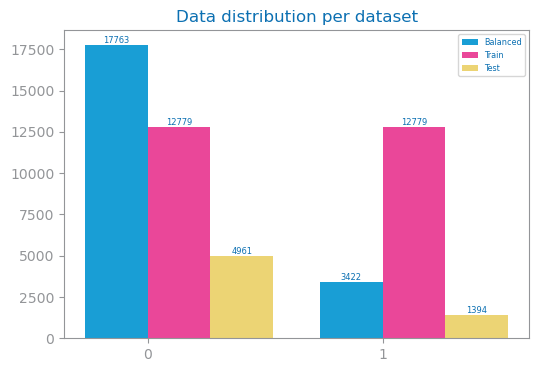

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# evaluate prep

In [6]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=25558 Test#=6355
Labels=[0, 1]


In [7]:
max_trees_eval=3000
max_trees_eval_lag=300

# F2 Evaluate for best model

## f2 study

GB best for 1100 trees (d=5 and lr=0.9


<Figure size 640x480 with 0 Axes>

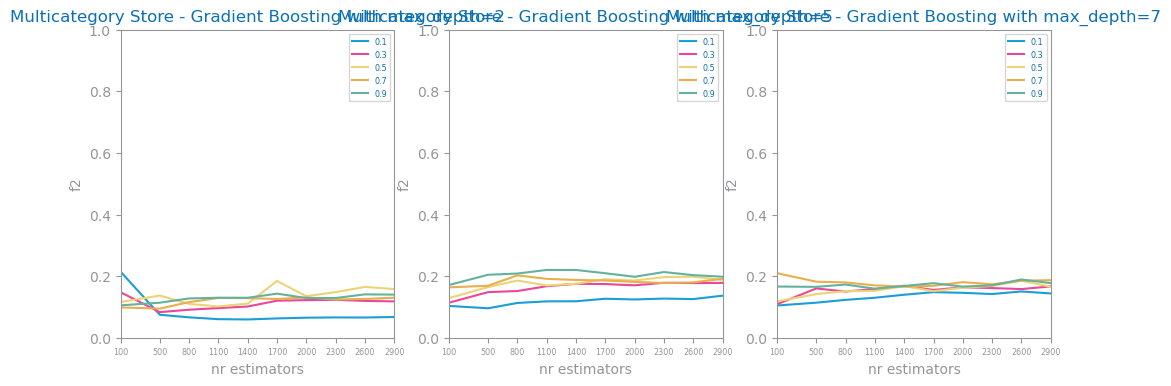

In [8]:
figure()


best_model_f2, f2_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
file_tag=file_tag
)

savefig(f'images/{file_tag}_GB_{f2_params['metric']}_study.png')
show()
    

## f2 Best Model Performance

<Figure size 640x480 with 0 Axes>

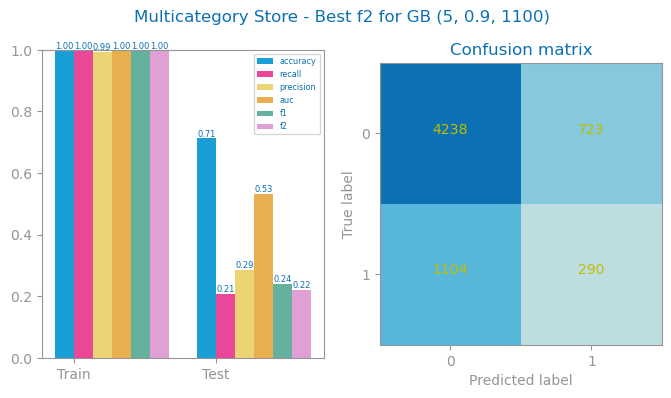

In [9]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_GB_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Variables importance


1. hour_cos (0.2247600356579125)
2. activity_in_session (0.20418826726401662)
3. day_of_week_sin (0.15582974054454882)
4. hour_sin (0.11293328830799397)
5. day (0.08322922732428323)
6. day_of_week_cos (0.07867548902472697)
7. product_category (0.05929857903614631)
8. price (0.05041049039119546)
9. week_of_month (0.015844403948745707)
10. brand_value (0.013754495815006533)
11. category_code_lvl_2 (0.0008992156768228883)
12. category_code_lvl_1 (0.0001767670086009013)


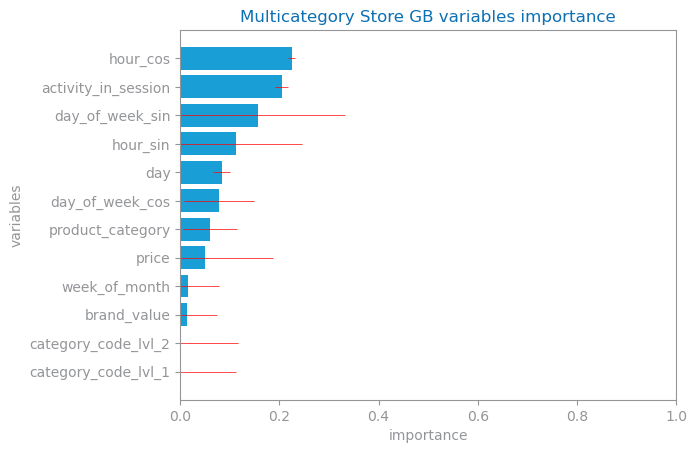

In [10]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_f2.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{f2_params["metric"]}_vars_ranking.png")

## f2 Overfitting

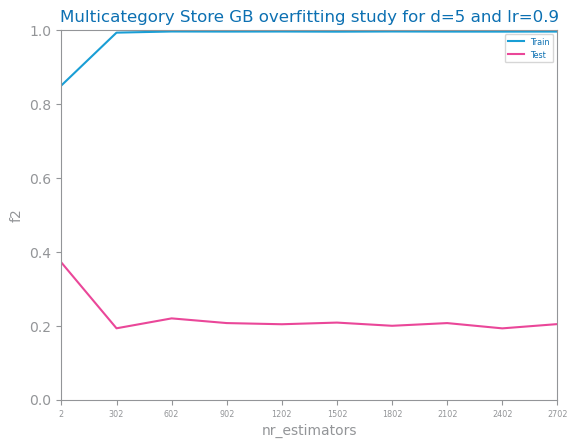

In [11]:

d_max: int = f2_params["params"][0]
lr: float = f2_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = f2_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Precision Evaluate for best model

## precision study

GB best for 100 trees (d=2 and lr=0.1


<Figure size 640x480 with 0 Axes>

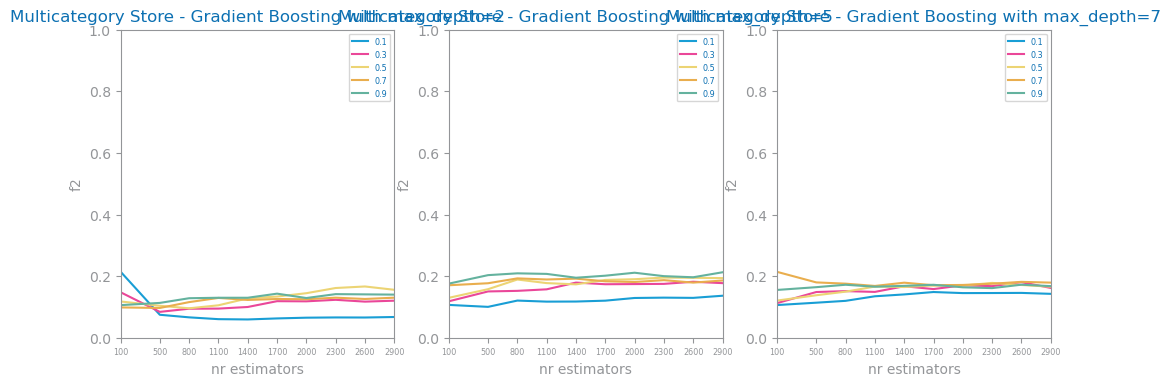

In [12]:
figure()


best_model_prec, prec_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
file_tag=file_tag

)

savefig(f'images/{file_tag}_GB_{prec_params['metric']}_study.png')
show()

## precision best model performance

<Figure size 640x480 with 0 Axes>

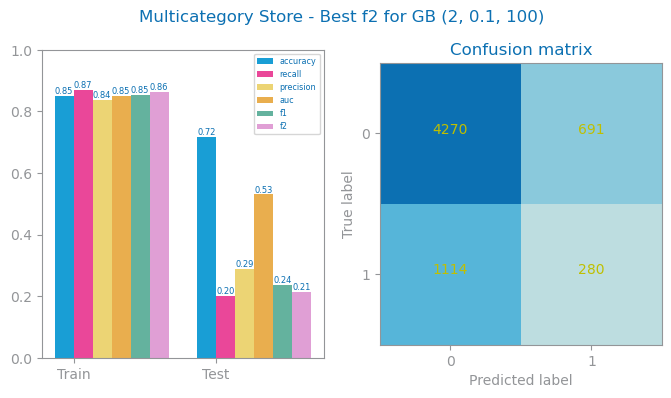

In [13]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_GB_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## precision Variables importance


1. hour_cos (0.22879254975635194)
2. activity_in_session (0.21629952258385485)
3. hour_sin (0.15766691949525288)
4. day_of_week_cos (0.13230521216009655)
5. day (0.11986701121790459)
6. day_of_week_sin (0.08230431638011226)
7. product_category (0.03341908754365643)
8. week_of_month (0.022677476390808717)
9. brand_value (0.005105812543993855)
10. price (0.0015620919279678363)
11. category_code_lvl_2 (0.0)
12. category_code_lvl_1 (0.0)


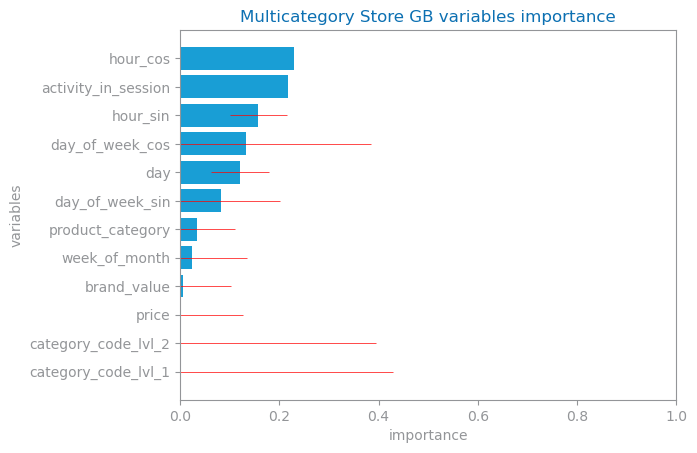

In [14]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_prec.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{prec_params["metric"]}_vars_ranking.png")

## precision overfitting

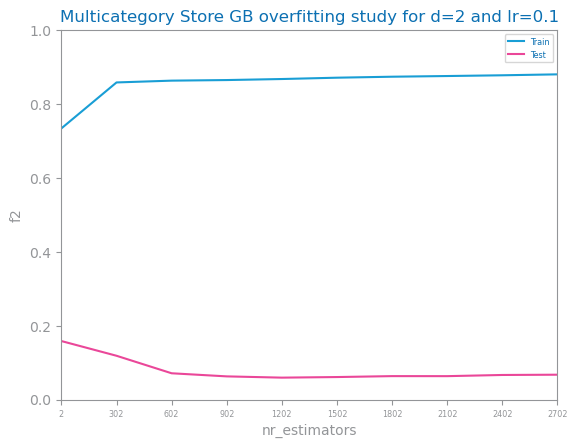

In [15]:

d_max: int = prec_params["params"][0]
lr: float = prec_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = prec_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
